In [1]:
import numpy as np
import pandas as pd
import json
from nltk import ngrams
import string
import random
import matplotlib as plt
from itertools import combinations
import csv

In [2]:
#The data file couldn't be checked into github because it is too large instead it must be downloaded here https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json
datafile =  'data/assignment2_aricles.json'

In [3]:
articles = pd.read_json(datafile, orient='records', encoding="utf-8")

## Tips: 

* Use string package to cleanup the articles e.g, str.maketrans('', '', string.punctuation)
* It is better to convert text to lower case that way you get fewer n-grams
* apply ngrams(x.split(), n) using ngrams from nltk on the content + title for computing n-grams, for this data n = 2 is suffcient

In [4]:
#You can use n-gram at word level for this task
#try with different n-gram values 
# You can use ngrams from nltk for this

def pre_process(text , n):
    
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = text.strip().replace('\n', ' ').lower()
    shingles = list(ngrams(text.split(), n))
    
    return shingles

def getNgrams(articles ,n):
    
    docs = []
    for i in range(len(articles)):
        
        A = pre_process((articles.iloc[i]['Title']) ,n)
        B = pre_process((articles.iloc[i]['Content']), n) 
        docs.append(A + B)
        
    return docs
    

In [5]:
# First we create n-grams for each article in the .json file

docs = getNgrams(articles ,2)

In [6]:
# This block create a set out of all unique shingles in all articles and save it to a variable named "terms"

terms = set()
for i in range(len(docs)): 
    terms.update(set(docs[i]))

In [7]:
# In this block of code I create a dictionary out of all shingles in the tesrms set. The keys of the dictionary are terms
# themselves and the corresponding values are their row indexes. Then for each specific term I can get their row index. 

def convert_set_2_dict(union_shingles):
    
    union_shingles_dict = dict()
    for i, j in enumerate(union_shingles):
        union_shingles_dict[j] = i
        
    return union_shingles_dict

In [8]:
union_shingles_dict = convert_set_2_dict(terms)

In [10]:
# We can see the number of unique 2-shingles below

print(len(union_shingles_dict))

3188968


## Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big.
For example, 
* Select top 10000 most frequent n-grams.
* You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
* Finally, you can also try sparse matrix representation. Like csr_matrix from  scipy.sparse. It works even with full vocabulary.
    * Given a list of n-grams for each document, see how to builid a sparse matrix here https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

**Explanation:** My implementation of getBinaryMatrix may differ to the proposed way above. Instead of creating a very sparse 
matrix due to the large number of terms and documents and then ran out of memory and seeking for a way for limitting
the top shingles of make use of scipy.sparse matrix , I created a dictionary which for each article  in my docs file,
it stores a list of corresponding row indexes which is extracted from unique_shingles_dict created in the previous code
block. By this way there is no need for storing too many zeros. Then in the upcomming sections I will hash these row 
indexes. With this methodology I was able to utilize all shigles without needing for limitting them. 

In [16]:
def getBinaryMatrix(docs , union_shingles_dict):
    
    d = {}
    
    for i, doc in enumerate(docs):
        idxs = []
            
        for word in doc:
            idx = union_shingles_dict[word]
            idxs.append(idx)
        
        d[i] = idxs
        
    return d    
    
    #return binary dictionary

In [13]:
binary_dict = getBinaryMatrix(docs , union_shingles_dict)

In [15]:
# check if the number of dictionary keys is equal to the number of true articles 

number_docs = len(list(binary_dict.keys()))
number_docs

48505

## We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much.

* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

**Explanation:** In this section I have implemented a hash function based on the proposed method in the Mining of Massive Datasets book, Chapter 3. For creating hash functions that map integer numbers in to distinct buckets  I used   (Ax + B)% numberofBuckets . The value of numberOfBuckets is the first prime number after the number of distinct buckets, in our case the number of rows. Thats why I chose 3188981 as an argument in my function because I have 3188968 distinct row indexes to be hashed in to buckets. Based on the number of chosen hash functions in order to create signature matrix, the pickRandomCoeffs would pick random coefficients for A and B for each hash function. 

In [17]:
def pickRandomCoeffs(k , numrows):
    
    randList = []
  
    while k > 0:
        randIndex = random.randint(0, numrows) 
  
        # Ensure that each random number is unique.
        while randIndex in randList:
            randIndex = random.randint(0, numrows) 
    
        # Add the random number to the list.
        randList.append(randIndex)
        k = k - 1
        
    return randList 



def getHashFunctionValues(numrows , numhashfunctions , nextPrime):
    
    coeffA = pickRandomCoeffs(numhashfunctions , numrows)
    coeffB = pickRandomCoeffs(numhashfunctions , numrows)
    
    hash_values= []
    
    for i in range(numhashfunctions):
        values = []
        for j in range(numrows):
        
            values.append((coeffA[i] * j + coeffB[i]) % nextPrime)
        
        hash_values.append(values)
        
                
               
    return hash_values
    
    #return a matrix with hash values

In [18]:
# number of shigles : 3188968
# number of hash_functions : 50
# prime number : 3188981

hash_val_matrix = getHashFunctionValues(3188968 , 60 , 3188981)

## Compute minhash following the faster algorithm from the lecture 

In [19]:
# instead of filling signature matrix with infinity in the first state of creating the matrix, I put the biggest 
# number possible which is the number of row indexes + 1. 

def getMinHashSignatureMatrix(binary_dict, hash_val_matrix , next_prime):
    
    signature = []
    for i in range (len(hash_val_matrix)):        # loop for each hash function
        row_signature = []
        for j in list(binary_dict.keys()):        # loop for each article 
            
            minHashCode = next_prime + 1
            
            for id in binary_dict[j]:             # loop for each hash value corresponding to each row index  
                
                hash_code = hash_val_matrix[i][id]
                
                if (hash_code < minHashCode):
                    minHashCode = hash_code
                    
            row_signature.append(minHashCode)
            
        signature.append(row_signature)
    
    return signature
    
    #return minhash signature matrix

In [20]:
signature_matrix = getMinHashSignatureMatrix(binary_dict, hash_val_matrix , 3188981)

In [21]:
# deleting some unused variables in order to free the memory a little bit

del docs
del terms 
del union_shingles_dict

## Hash signature bands into buckets. Find a way to combine all the signature values in a band and hash them into a number of buckets ususally very high.
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before
* You should use the same hash function for all bands. And all documents ending up in same bucket for at least one band are considered as candidate pairs.

**Explanation:** After splitting the signature matrix based on the chosen number of bands, we convert each sub-column for each article in to string and hash it based on a simple hash function and create a bucket dictionary in each band. The keys for this dictionary is distinc hash values and the corresponding values are article numbers stored in a list which has the same hash values. In other words, the combinations between each pair of these article numbers are candidate pairs. The output of this function is a set named candidate pairs which is updated for each distinct candidate pairs in each loop.  

In [22]:
def getLSH(signature_matrix, num_bands , num_buckets):
   
    bands = []

    for i in range(0, num_bands):
        bands.append(np.split(np.array(signature_matrix), num_bands)[i])
    
    buckets = {}
    candidate_pairs = set()
    
    for i in range(0, len(bands)):
        buckets = {}
        randint = random.randint(0, 1000000)
        for j in range(0, bands[i].shape[1]):
            arr = str(bands[i][:,j])
            hashes = (hash(arr)^randint) % num_buckets
            if hashes in buckets:
                buckets[hashes].append(j)
            else:
                buckets.update({hashes:[j]})
        
             
        a = [list(combinations(buckets[keys] , 2)) for keys in buckets.keys() if (len(buckets[keys]) > 1)]
        terms = set()
        for i in range(len(a)): 
            terms.update(set(a[i]))
        
        candidate_pairs = ( candidate_pairs | terms )

        
    return candidate_pairs

In [25]:
# defining a function for calculating jacard_similarity in the case we wanted to check whether the candidate pairs are 
# truely pair or not

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(set(list2))))
    union = (len(list1) + len(list2)) 
    return float(intersection) / union

## Tune parameters to make sure the threshold is appropriate.
## plot the probability of two similar items falling in same bucket for different threshold values


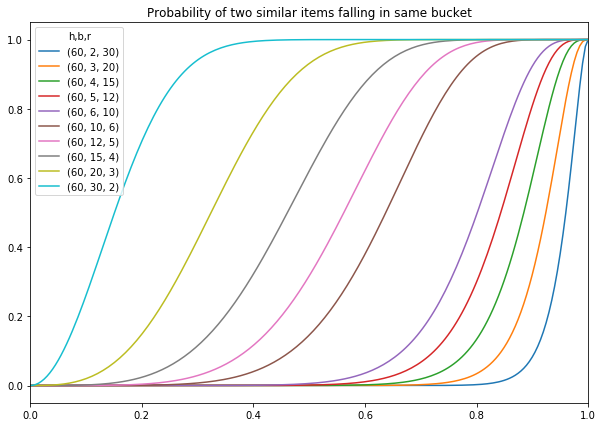

In [23]:
df = pd.DataFrame(data=[(2, 30), (30, 2), (3, 20), (20, 3), (4, 15), (15, 4), (5, 12), (12, 5), (6, 10), (10, 6)], columns=['b', 'r'])
df['h'] = df['b'] * df['r']
for pr in np.linspace(0, 1, 200):
    df[pr] = 1 - (1 - pr**df['r']) ** df['b']
df = pd.pivot_table(df, index=['h','b', 'r'])
ax = df.T.plot(figsize=(10, 7), title='Probability of two similar items falling in same bucket');

## Choose the best parameters and get nearest neighbors of each articles

**Exlanation:** Based on the tuning plot above we can conclude that in order to get the nearest neighbor for each article 
I chose 12 as the total number of bands for the total of 60 distinct hash functions. which is 5 rows per band. I chose a very big number for the total number of buckets in order to ensure that candidate pairs are placed in the similar bucket. 

In [24]:
bands = getLSH(signature_matrix , 12 , 10000000000000)

## Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score

In [26]:
def createSubmission(candidate_pairs , total_lines):
    
    with open("./submissions.csv", 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        
        for i in range(total_lines):
            line = []
            line.append(int(i))

            for item in candidate_pairs :

                if i == item[0] :

                    line.append(int(item[1])) 

                elif i == item[1] :

                    line.append(int(item[0]))

                else :
                    continue 
            
            wr.writerow(line)       
    

In [ ]:
createSubmission(bands , number_docs) 